In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(46)
torch.set_default_device(device)

device

'cuda'

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())
X_train_not_normalized = train_data.data.float().to(device=device)
y_train = train_data.targets.to(device=device)
X_test_not_normalized = test_data.data.float().to(device=device)
y_test = test_data.targets.to(device=device)

X_train = (X_train_not_normalized - X_train_not_normalized.min()) / (
    X_train_not_normalized.max() - X_train_not_normalized.min()
)
X_test = (X_test_not_normalized - X_test_not_normalized.min()) / (
    X_test_not_normalized.max() - X_test_not_normalized.min()
)

In [3]:
class Teacher(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.activation_function = nn.ReLU()

        self.flatten = nn.Flatten()

        self.layer_one = nn.Linear(
            in_features=784, out_features=1024, dtype=torch.float
        )
        self.layer_two = nn.Linear(
            in_features=1024, out_features=512, dtype=torch.float
        )
        self.layer_three = nn.Linear(
            in_features=512, out_features=10, dtype=torch.float
        )

    def forward(self, x: torch.Tensor):
        out = self.flatten(x)
        out = self.activation_function(self.layer_one(out))
        out = self.activation_function(self.layer_two(out))
        out = self.layer_three(out)
        return out


model = Teacher()

In [4]:
import math
import matplotlib.pyplot as plt


EPOCHS = 20
ALPHA = 0.01
BATCH_SIZE = 32
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=ALPHA)


def printLogs(epoch, epochs, loss, accuracy, test_accuracy, test_loss):
    print(
        f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%  | Test loss: {test_loss:.5f}"
    )


general_loss = []  # to be shown after epochs
general_test_loss = []  # to be shown after epochs
general_accuracy = []  # to be shown after epochs
general_test_accuracy = []  # to be shown after epochs
for epoch in range(EPOCHS):
    accuracies = []
    test_accuracies = []
    test_losses = []
    losses = []
    for batch_index in range(math.ceil(X_train.shape[0] / BATCH_SIZE)):
        model.train()
        X_train_batch = X_train[
            batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
        ]
        y_train_batch = y_train[
            batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
        ]
        y_logits = model(X_train_batch)
        y_preds = torch.softmax(y_logits, dim=1)
        _, max_indices = y_preds.max(dim=1)

        accuracy = (
            torch.eq(y_train_batch, max_indices).sum().item() / len(y_train_batch) * 100
        )
        accuracies.append(accuracy)

        loss = loss_function(y_logits, y_train_batch)

        losses.append(loss.cpu())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model.eval()

        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_preds = torch.softmax(test_logits, dim=1)

            _, max_indices = test_preds.max(dim=1)
            test_loss = loss_function(test_logits, y_test)

            test_accuracy = (
                torch.eq(y_test, max_indices).sum().item() / len(y_test) * 100
            )

            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss.cpu())

    average_test_loss = torch.tensor(test_losses).mean()
    average_loss = torch.tensor(losses).mean()
    average_test_accuracy = torch.tensor(test_accuracies).mean()
    average_accuracy = torch.tensor(accuracies).mean()

    test_losses = []  # reset for the next epoch
    losses = []
    test_accuracies = []
    accuracies = []

    general_loss.append(average_loss.item())
    general_test_loss.append(average_test_loss.item())
    general_test_accuracy.append(average_test_accuracy.item())
    general_accuracy.append(average_accuracy.item())
    printLogs(
        epoch,
        EPOCHS,
        average_loss,
        average_accuracy,
        average_test_accuracy,
        average_test_loss,
    )

Epoch: 0 | Loss: 0.97844, Accuracy: 78.32%, Test Accuracy: 78.59%  | Test loss: 0.96445
Epoch: 1 | Loss: 0.34358, Accuracy: 90.31%, Test Accuracy: 90.49%  | Test loss: 0.33282
Epoch: 2 | Loss: 0.28301, Accuracy: 91.95%, Test Accuracy: 92.11%  | Test loss: 0.27628
Epoch: 3 | Loss: 0.24435, Accuracy: 93.02%, Test Accuracy: 93.12%  | Test loss: 0.24087
Epoch: 4 | Loss: 0.21372, Accuracy: 93.88%, Test Accuracy: 93.85%  | Test loss: 0.21278
Epoch: 5 | Loss: 0.18875, Accuracy: 94.65%, Test Accuracy: 94.47%  | Test loss: 0.18989
Epoch: 6 | Loss: 0.16817, Accuracy: 95.22%, Test Accuracy: 94.97%  | Test loss: 0.17122
Epoch: 7 | Loss: 0.15100, Accuracy: 95.72%, Test Accuracy: 95.39%  | Test loss: 0.15580
Epoch: 8 | Loss: 0.13640, Accuracy: 96.14%, Test Accuracy: 95.77%  | Test loss: 0.14295
Epoch: 9 | Loss: 0.12385, Accuracy: 96.45%, Test Accuracy: 96.10%  | Test loss: 0.13219
Epoch: 10 | Loss: 0.11299, Accuracy: 96.77%, Test Accuracy: 96.36%  | Test loss: 0.12313
Epoch: 11 | Loss: 0.10350, Accu

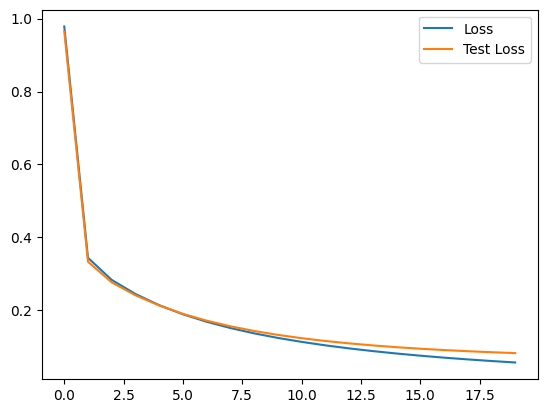

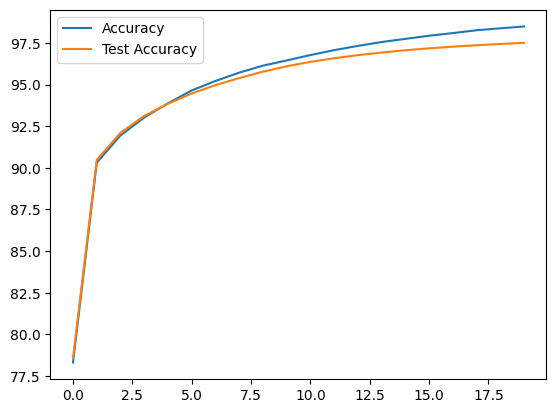

In [5]:
plt.plot(general_loss, label="Loss")
plt.plot(general_test_loss, label="Test Loss")
plt.legend()
plt.show()
plt.plot(general_accuracy, label="Accuracy")
plt.plot(general_test_accuracy, label="Test Accuracy")
plt.legend()
plt.show()

Misclassification on test data: 268 out of 10000


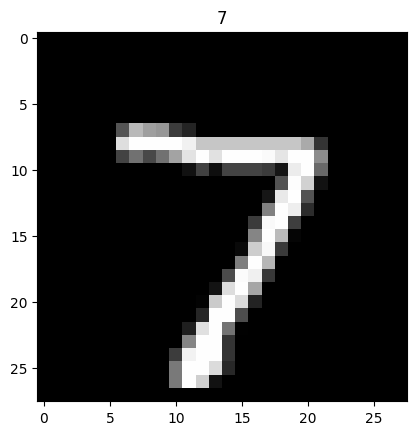

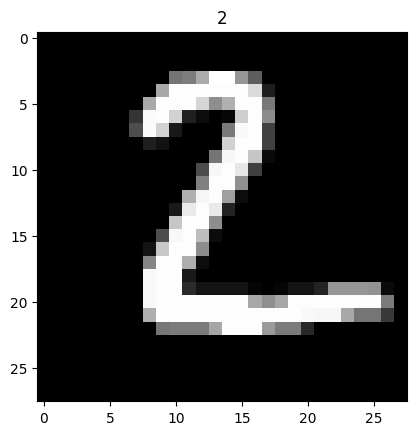

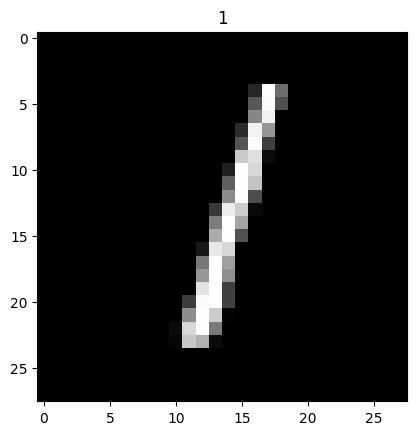

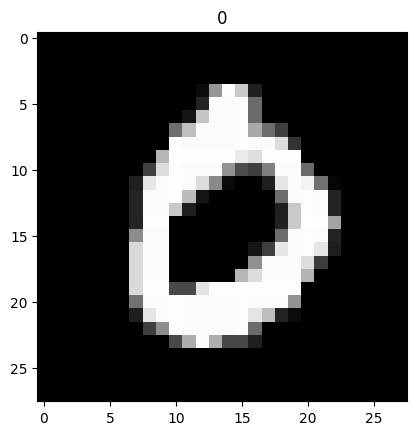

In [6]:
_, indices = torch.softmax(model(X_test_not_normalized), 1).max(dim=1)
print(
    f"Misclassification on test data: {torch.not_equal(y_test, indices).sum().item()} out of {len(y_test)}"
)

for i in range(4):
    plt.imshow(X_test_not_normalized[i].cpu(), cmap="gray")
    plt.title("%i" % indices[i])
    plt.show()